# Music Generation

In [133]:
import pyaudio
import math
from numpy import fromstring,linspace,sin,pi,int8,int16,rint,sign,arcsin,tan,arctan,cos,append,multiply,add,subtract,divide,repeat,random,clip,fft,zeros,cumsum,minimum,concatenate,transpose,ascontiguousarray,vstack,copy
import time
import pandas as pd
from enum import Enum
from scipy.io import wavfile
from scipy.signal import stft,istft
import sounddevice as sd

In [3]:
%matplotlib inline

In [4]:
#p = pyaudio.PyAudio()
#for i in range(p.get_device_count()):
#    dev = p.get_device_info_by_index(i)
#    print((i,dev['name'],dev['maxInputChannels']))
#
#stream = p.open(output=True, channels=2, rate=RATE, format=pyaudio.paInt16, output_device_index=1)

## Constants

In [5]:
RATE=44100

In [6]:
stream = sd.OutputStream(samplerate=RATE, dtype=int16, channels=2)
stream.start()

## Utilities

In [7]:
class Note(Enum):
    C3 = 131
    D3 = 147
    E3 = 165
    F3 = 175
    G3 = 196
    A4 = 220
    B4 = 247
    C4 = 262

In [8]:
def inspect_sound(sound_data):
    df = pd.DataFrame(sound_data)
    print("shape: ", df.shape)
    print("head: ")
    df.head(101).plot()
    stream.write(df.values)

## Signal Generators

In [349]:
def wave(frequency=Note.C3.value, length=1, amplitude=8000, phase=0, sample_rate=RATE, function=None, function_args=None):
    time = linspace(0,length,length*sample_rate)
    wavelength = 1/frequency
    data = function(time, wavelength, amplitude, phase, function_args)
    #data = data.astype(int16) # two byte integers
    data = mono_to_stereo(data)
    return data.astype(int16)

In [350]:
def sine_function(time, wavelength, amplitude, phase, function_args=None):
    return amplitude * sin((2*pi*time - phase)/wavelength)

In [351]:
def square_function(time, wavelength, amplitude, phase, function_args=None):
    return amplitude * sign(sin((2*pi*time - phase)/wavelength))

In [352]:
def triangle_function(time, wavelength, amplitude, phase, function_args=None):
    return (2*amplitude/pi) * arcsin(sin((2*pi*time - phase)/wavelength))

In [353]:
def sawtooth_function(time, wavelength, amplitude, phase, function_args=None):
    return (2*amplitude/pi) * arctan(tan((2*pi*time - phase)/(2*wavelength)))

In [354]:
def inverse_sawtooth_function(time, wavelength, amplitude, phase, function_args=None):
    return (2*amplitude/pi) * arctan(tan((2*pi*time - phase)/(2*wavelength))) * -1

In [355]:
def pulse_function(time, wavelength, amplitude, phase, function_args):
    pulse_width = function_args['pulse_width']
    return amplitude * sign(sin((2*pi*time - phase)/wavelength)-(1-pulse_width))

In [356]:
def white_noise_function(time, wavelength, amplitude, phase, function_args):
    return random.random(len(time))*amplitude

In [357]:
def silence(time, wavelength, amplitude, phase, function_args):
    return zeros(len(time))

In [358]:
def identity(signal):
    return signal

In [359]:
def frequency_modulation_synthesizer(carrier=Note.C3.value, length=1, amplitude=5000, sample_rate=RATE, modulation_depth=0, modulation_frequency=0):
    time = linspace(0,length,length*sample_rate)
    signal = (amplitude*sin(2*pi*time*carrier + modulation_depth*sin(2*pi*time*modulation_frequency)))
    signal = mono_to_stereo(signal)
    return signal.astype(int16)

In [360]:
def sampler(path):
    sample = wavfile.read(path)[1]
    if sample.ndim == 1:
        return mono_to_stereo(sample).astype(int16)
    elif sample.ndim == 2:
        return sample.astype(int16)
    else:
        raise ValueError('Sound has too many dimensions.  Only mono (_, 1) and stereo (_, 2) are supported.')

## Plugins

In [361]:
def linear_asdr_envelope(sound, attack, decay, sustain, release):
    if sound.ndim == 1:
        return linear_asdr_envelope_mono(sound, attack, decay, sustain, release)
    elif sound.ndim == 2:
        return linear_asdr_envelope_stereo(sound, attack, decay, sustain, release)
    else:
        raise ValueError('Sound has too many dimensions.  Only mono (_, 1) and stereo (_, 2) are supported.')

def linear_asdr_envelope_mono(sound, attack, decay, sustain, release):
    peak = sound.max()
    a = linspace(0,1,RATE*attack)
    d = linspace(1,sustain,RATE*decay)
    s = linspace(sustain,sustain,len(sound)-(RATE*(attack+decay+release)))
    r = linspace(sustain,0,RATE*release)
    envelope = append(append(a,d),append(s,r))
    return multiply(envelope,sound).astype(int16)

def linear_asdr_envelope_stereo(sound, attack, decay, sustain, release):
    peak = sound.max()
    a = linspace(0,1,RATE*attack)
    d = linspace(1,sustain,RATE*decay)
    s = linspace(sustain,sustain,len(sound)-(RATE*(attack+decay+release)))        
    r = linspace(sustain,0,RATE*release)
    envelope = append(append(a,d),append(s,r))
    envelope = mono_to_stereo(envelope)
    return multiply(envelope,sound).astype(int16)

In [362]:
def time_warp(sound, coefficient):
    if sound.ndim == 1:
        return time_warp_mono(sound, coefficient)
    elif sound.ndim == 2:
        return time_warp_stereo(sound, coefficient)
    else:
        raise ValueError('Sound has too many dimensions.  Only mono (_, 1) and stereo (_, 2) are supported.')

def time_warp_mono(sound, coefficient):
    if coefficient >= 1:
        return repeat(sound, coefficient)
    else:
        slicer = int(1 / coefficient)
        return sound[0::slicer].astype(int16)

def time_warp_stereo(sound, coefficient):
    if coefficient >= 1:
        return repeat(sound, coefficient, axis=0)
    else:
        slicer = int(1 / coefficient)
        return sound[0::slicer].astype(int16)

In [363]:
def lfo(sound, frequency, amount=1, wave_function=sine_function, wave_function_args={}):
    lfo = wave(function=wave_function, frequency=frequency, length=int(len(sound)/RATE), function_args=wave_function_args)
    lfo = add(lfo, lfo.max()) # shift lfo to positive
    lfo = divide(lfo,lfo.max()) # Make lfo range 0 to 1
    lfo = multiply(lfo,amount) # scale lfo by amount
    lfo = add(lfo, (1-amount)) # shift lfo up so peak is at 1 and min is (1-amount)
    return multiply(lfo,sound).astype(int16)

In [365]:
def arpeggiator(sound, step_size, frequency):
    return lfo(sound, frequency=frequency, wave_function=pulse_function, wave_function_args={'pulse_width':step_size}).astype(int16)

In [366]:
def distortion(sound, amount):
    sound = multiply(sound, amount)
    amount = 1 / amount
    return clip(sound, int(sound.min()*amount), int(sound.max()*amount)).astype(int16)

In [367]:
def utility(sound, amount):
    return multiply(sound, amount).astype(int16)

In [368]:
def limiter(signal, amount):
    signs = sign(signal)
    return multiply(minimum(abs(signal),signal.max() * amount), signs).astype(int16)

In [369]:
def offset(sound, length=0):
    shift_amount = int(min(abs(length*RATE), len(sound)))
    shifted = zeros(sound.shape)
    if length >=0:
        shifted[shift_amount:] = sound[0:len(sound)-shift_amount]
    else:
        shifted[0:shift_amount] = sound[len(sound) - shift_amount:]
    return shifted.astype(int16)

In [370]:
def moving_average_low_pass_filter(sound, periods):
    max_amplitude = sound.max()
    cumulative = cumsum(sound)
    cumulative[periods:] = cumulative[periods:] - cumulative[:-periods]
    unadjusted = cumulative[periods - 1:] / periods
    louder = (max_amplitude / unadjusted.max()) * unadjusted
    return (louder).astype(int16)

In [371]:
def stft_low_pass_filter(sound, cutoff, amount=0):
    f, t, Zxx = stft(sound)
    for i,x in enumerate(Zxx.real):
        if i > cutoff:
            Zxx[i] = multiply(Zxx[i],zeros(x.shape)+amount)
    return istft(Zxx)[1].astype(int16)

In [372]:
def stft_high_pass_filter(sound, cutoff, amount=0):
    f, t, Zxx = stft(sound)
    for i,x in enumerate(Zxx.real):
        if i < cutoff:
            Zxx[i] = multiply(Zxx[i],zeros(x.shape)+amount)
    return istft(Zxx)[1].astype(int16)

In [373]:
def stft_band_pass_filter(sound, cutoff_lo, cutoff_hi, amount=0):
    f, t, Zxx = stft(sound)
    for i,x in enumerate(Zxx.real):
        if i < cutoff_lo or i > cutoff_hi:
            Zxx[i] = multiply(Zxx[i],zeros(x.shape)+amount)
    return istft(Zxx)[1].astype(int16)

In [374]:
def add_waves(sound1, sound2):
    if len(sound1) < len(sound2):
        combined = sound2.copy()
        combined[:len(sound1)] += sound1
    else:
        combined = sound1.copy()
        combined[:len(sound2)] += sound2
    return combined.astype(int16)

In [375]:
def fade_out(sound, amount=None, fade_function=linspace):
    if sound.ndim == 1:
        return fade_out_mono(sound, amount=amount, fade_function=fade_function)
    elif sound.ndim == 2:
        return fade_out_stereo(sound, amount=amount, fade_function=fade_function)
    else:
        raise ValueError('Sound has too many dimensions.  Only mono (_, 1) and stereo (_, 2) are supported.')

def fade_out_mono(sound, amount=None, fade_function=linspace):
    if amount is None:
        fade_length = 10
    else:
        fade_length = len(sound) * amount
    fade_length = min(fade_length, len(sound))
    fade_length = int(fade_length)
    fade_amount = linspace(1,0,fade_length)
    padding = add(zeros(len(sound) - fade_length),1)
    fade_amount = concatenate((padding, fade_amount))
    return multiply(sound, fade_amount).astype(int16)

def fade_out_stereo(sound, amount=None, fade_function=linspace):
    if amount is None:
        fade_length = 10
    else:
        fade_length = len(sound) * amount
    fade_length = min(fade_length, len(sound))
    fade_length = int(fade_length)
    fade_amount = linspace(1,0,fade_length)
    fade_amount = mono_to_stereo(fade_amount)
    padding = add(zeros(len(sound) - fade_length),1)
    padding = mono_to_stereo(padding)
    fade_amount = concatenate((padding, fade_amount))
    return multiply(sound, fade_amount).astype(int16)

In [376]:
def fade_in(sound, amount=None, fade_function=linspace):
    if sound.ndim == 1:
        return fade_in_mono(sound, amount=amount, fade_function=fade_function)
    elif sound.ndim == 2:
        return fade_in_stereo(sound, amount=amount, fade_function=fade_function)
    else:
        raise ValueError('Sound has too many dimensions.  Only mono (_, 1) and stereo (_, 2) are supported.')

def fade_in_mono(sound, amount=None, fade_function=linspace):
    if amount is None:
        fade_length = 10
    else:
        fade_length = len(sound) * amount
    fade_length = min(fade_length, len(sound))
    fade_length = int(fade_length)
    fade_amount = linspace(0,1,fade_length)
    padding = add(zeros(len(sound) - fade_length),1)
    fade_amount = concatenate((fade_amount,padding))
    return multiply(sound, fade_amount).astype(int16)

def fade_in_stereo(sound, amount=None, fade_function=linspace):
    if amount is None:
        fade_length = 10
    else:
        fade_length = len(sound) * amount
    fade_length = min(fade_length, len(sound))
    fade_length = int(fade_length)
    fade_amount = linspace(0,1,fade_length)
    fade_amount = mono_to_stereo(fade_amount)
    padding = add(zeros(len(sound) - fade_length),1)
    padding = mono_to_stereo(padding)
    fade_amount = concatenate((fade_amount,padding))
    return multiply(sound, fade_amount).astype(int16)

In [394]:
def fade(sound, amount=None, fade_function=linspace):
    return (fade_out(fade_in(sound, amount=amount, fade_function=fade_function),amount=amount, fade_function=fade_function)).astype(int16)

In [378]:
def mono_to_stereo(sound):
    return ascontiguousarray(transpose(vstack((sound,sound))))

In [418]:
def pad(sound, length):
    length *= RATE
    length = int(length)
    if len(sound) == length:
        return sound
    elif len(sound) > length:
        return sound[:length]
    else:
        remaining = length - len(sound)
        return concatenate((sound, mono_to_stereo(zeros(remaining)))).astype(int16)

In [380]:
def balance(sound, l_r_balance=0.5):
    if l_r_balance > 1:
        l_r_balance = 1
    elif l_r_balance < 0:
        l_r_balance = 0
    
    if sound.ndim == 1:
        return balance_mono(sound, l_r_balance)
    elif sound.ndim == 2:
        return balance_stereo(sound, l_r_balance)
    else:
        raise ValueError('Sound has too many dimensions.  Only mono (_, 1) and stereo (_, 2) are supported.')

def balance_mono(sound, l_r_balance):
    return sound

def balance_stereo(sound, l_r_balance):
    sound = copy(sound) # making function pure by not mutating original sound
    l_r_balance *= 2
    l_balance = 2 - l_r_balance
    r_balance = l_r_balance
    sound[:,0] = multiply(sound[:,0],l_balance)
    sound[:,1] = multiply(sound[:,1],r_balance)
    return sound.astype(int16)

## Instruments

In [403]:
kick_thump = wave(function=sine_function, length=0.5, frequency=Note.C3.value/2)
kick_attack = linear_asdr_envelope(wave(function=white_noise_function, length=0.1, frequency=Note.C3.value*5),0,0.03,0,0)
#kick = add_waves(kick_thump,kick_thump)
kick = kick_thump
stream.write(kick)

D:\Users\Pat\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  
D:\Users\Pat\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
D:\Users\Pat\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


False

In [552]:
kick_hi_thump = linear_asdr_envelope(wave(function=sine_function, length=0.75, frequency=Note.C3.value/5),0.1,0.5,0.2,0)
kick_hi_attack = linear_asdr_envelope(wave(function=sine_function, length=0.5, frequency=Note.C3.value/2),0,0.2,0,0)
kick_hi = add_waves(kick_hi_thump,kick_hi_attack)
kick_hi = time_warp(kick_hi,0.4)
stream.write(kick_hi)

D:\Users\Pat\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  
D:\Users\Pat\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
D:\Users\Pat\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
D:\Users\Pat\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


False

In [397]:
rest = wave(function=silence, length=1)

In [504]:
snare_attack = wave(function=sawtooth_function, length=0.01, frequency=Note.C3.value)
snare_sizzle = linear_asdr_envelope(wave(function=white_noise_function, length=1, frequency=Note.C3.value),0.2,0.5,0,0)
snare_sizzle = utility(snare_sizzle, 0.5)
snare_sizzle_2 = linear_asdr_envelope(wave(function=sine_function, length=1, frequency=Note.C3.value/4),0.01,0.5,0,0)
snare = add_waves(snare_attack,snare_sizzle)
snare = add_waves(snare, snare_sizzle_2)
snare = time_warp(snare,0.15)
stream.write(snare)

D:\Users\Pat\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  
D:\Users\Pat\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
D:\Users\Pat\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
D:\Users\Pat\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


False

In [567]:
hi_hat = linear_asdr_envelope(wave(function=white_noise_function, length=1, frequency=Note.C3.value),0,0.1,0.1,0)
hi_hat = time_warp(hi_hat, 0.2)
stream.write(hi_hat)

D:\Users\Pat\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
D:\Users\Pat\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


False

## Workspace

In [821]:
from numpy import setdiff1d,array
from numpy.linalg import norm
from scipy.optimize import minimize, differential_evolution
from scipy.fftpack import fft

In [638]:
SOUND = sampler("D:\Pat\projects\programming\music generation\samples\Galactica - C3 - 2.wav")

In [684]:
def play_sound(d1, f1, d2, f2):
    fm1 = frequency_modulation_synthesizer(length=1, modulation_depth=d1, modulation_frequency=f1)
    fm2 = frequency_modulation_synthesizer(length=1, modulation_depth=d2, modulation_frequency=f2)
    fm3 = add_waves(fm1, fm2)
    return fm3

In [852]:
def sound_replication(x0):
    d1 = x0[0]
    d2 = x0[2]
    f1 = x0[1]
    f2 = x0[3]
    fm1 = frequency_modulation_synthesizer(length=1, modulation_depth=d1, modulation_frequency=f1)
    fm2 = frequency_modulation_synthesizer(length=1, modulation_depth=d2, modulation_frequency=f2)
    fm3 = add_waves(fm1, fm2)
    #s1 = stft(SOUND,nperseg=1000)[2]
    #s2 = stft(fm3,nperseg=1000)[2]
    fft_size = 5000
    s1 = fft(SOUND, fft_size, axis=0)[:,0]
    s2 = fft(fm3, fft_size, axis=0)[:,0]
    return norm(subtract(s1,s2))
    #return d1 - 0

In [845]:
x0 = array([10., 400., 5., 50.])
bounds = [(0,30),(0, 500),(0,30),(0,500)]

In [853]:
#res = minimize(sound_replication, x0, bounds=bounds, method='SLSQP', options={'disp': True})
res = differential_evolution(sound_replication, bounds=bounds)
print(res.x, ' vs ', x0)

[   3.12973284   66.27546098    1.60632581  132.98170635]  vs  [  10.  400.    5.   50.]


In [865]:
stream.write(play_sound(res.x[0], res.x[1], res.x[2], res.x[3]))

False

In [866]:
stream.write(SOUND)

False

In [835]:
stream.write(play_sound(2.8, 134, 0.16, 4359))

False

In [823]:
stream.write(play_sound(x0[0],x0[1],x0[2],x0[3]))

False

### -

In [817]:
fm1 = frequency_modulation_synthesizer(length=1, modulation_depth=11, modulation_frequency=Note.C3.value/2)
#fm1 = linear_asdr_envelope(fm1, 0.1, 0.25, 0.25, 0)
fm3 = frequency_modulation_synthesizer(length=1, modulation_depth=5, modulation_frequency=Note.C3.value/4)
#fm3 = linear_asdr_envelope(fm3, 0.2, 0.5, 0.5, 0)

fm2 = add_waves(fm1, fm3)

stream.write(fm2)
#pd.DataFrame(fm2).head(1000).plot()

False

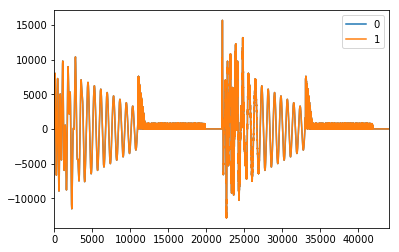

In [627]:
amount = None
a = pad(fade(kick_hi,amount=amount),0.25)
b = pad(fade(hi_hat,amount=amount),0.25)
c = pad(utility(fade(snare,amount=amount), 0.65),0.25) + a
d = pad(fade(hi_hat,amount=amount),0.25)
ftest2 = concatenate((a,b,c,d))
pd.DataFrame(ftest2).plot()

In [628]:
stream.write(ftest2)

False

#### -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Notes

### TODO
- Convert every function to handle both stereo and mono (originally designed for mono)

- LFO (works on sounds but not samples?)
- ADSR envelope
- Filters (FFT?)
- Arp (very simplistic right now.  Add a function to it for stepping up each note.  Pass Identity fun by default)
- Sampler
- How to change BPM?
    - should it be during playback like changing the stream rate
    - can I double every value in the array to make twice as long?
- distortion
- limiter
- "utility"
- fade in, fade out


- Oscilator (wav combiners) or combining of synths.
- mono to stereo and back
- stereo spread
- crossfade
- reverb
- delay
- style transfer of samples (vocoder?)

### HOW TO USE
stream.write(wave(function=sine_function))

stream.write(wave(function=square_function))

stream.write(wave(function=triangle_function))

stream.write(wave(function=sawtooth_function))

stream.write(wave(function=pulse_function, function_args={'pulse_width':0.25}))

stream.write(wave(function=white_noise_function))

stream.write(linear_asdr_envelope(wave(function=square_function, length=6), 1, 1, 0.5, 1))

stream.write(wave(function=sine_function, length=3, frequency=Note.C3.value, amplitude=5000)+wave(function=sine_function, length=3, frequency=Note.C3.value*2, amplitude=2000))

stream.write(lfo(wave(function=sawtooth_function,length=9),frequency=3, amount=1))

stream.write(distortion(wave(function=sawtooth_function), 10))

stream.write(utility(wave(function=sawtooth_function, length=3), 2))

stream.write(frequency_modulation_synthesizer(length=4, modulation_depth=20, modulation_frequency=Note.C3.value))

stream.write(offest(wave(function=sine_function),0.5))

stft_low_pass_filter(signal,3,0.25)

limiter(sig,0.5)

##### Sampler
path = "D:\\Pat\\projects\\programming\\Accent Removal\\Samples\\wavs\\samplewav.wav"

sampler("D:\Pat\projects\programming\Accent Removal\Samples\wavs\samplewav.wav")

sig = frequency_modulation_synthesizer(length=1, modulation_depth=15, modulation_frequency=Note.C3.value+15)
stream.write(limiter(sig,0.5))

saw_c = wave(function=sawtooth_function, length=1, frequency=Note.C3.value)
saw_e = wave(function=sawtooth_function, length=1, frequency=Note.E3.value)
saw_g = wave(function=sawtooth_function, length=1, frequency=Note.G3.value)
saw_b = wave(function=sawtooth_function, length=1, frequency=Note.B4.value)
rest = wave(function=silence, length=1)

stream.write(saw_c)
stream.write(saw_e)
stream.write(saw_g)
stream.write(saw_c)
stream.write(saw_e)
stream.write(saw_g)
stream.write(saw_c)
stream.write(saw_e)
stream.write(saw_g)
stream.write(saw_c)
stream.write(saw_e)
stream.write(saw_g)
stream.write(rest)
stream.write(saw_e)
stream.write(saw_g)
stream.write(saw_b)
stream.write(saw_e)
stream.write(saw_g)
stream.write(saw_b)
stream.write(saw_e)
stream.write(saw_g)
stream.write(saw_b)
stream.write(saw_e)
stream.write(saw_g)
stream.write(saw_b)